# Set Environment

In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import tensorflow.keras 
from tensorflow.keras import backend as K
import glob

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

# Saved Face Descriptions

In [2]:
def find_faces(img):
    dets = detector(img, 1)

    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    for k, d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        shape = sp(img, d)
        
        # convert dlib shape to numpy array
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

        shapes.append(shape)
        
    return rects, shapes, shapes_np


def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)

In [3]:
label_name = []
label_class = {}
img_paths = glob.glob("kpop_img/*")

for path in img_paths:
    name = path.split(".")[0][9:]
    label_name.append(name)
    label_class[name] = path

#print(label_name)
print(len(label_class))

99


In [4]:
descs = []

for name, label_path in label_class.items():
    img = cv2.imread(label_path)
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
    _, img_shapes, _ = find_faces(img)
    descs.append([name, encode_faces(img, img_shapes)[0]])

np.save('descs.npy', descs)
#print(descs)

# Load Face Descriptions

In [5]:
descs = np.load('descs.npy', allow_pickle=True)

# 닮은 연예인 찾기(저장된 사진으로 찾기)

In [6]:
def draw(img, comment, x, y, h, size):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((x+5,y+h), comment, font=ImageFont.truetype("./batang.ttc", size), fill=(40,180,120))
    
    return np.array(img)  

거리: 0.361
taeyeon을 닮으셨네요. 올~~


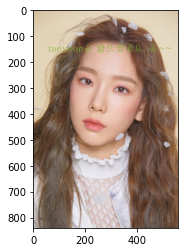

In [7]:
img = cv2.imread('test_img/taeyeon.jpg')
#img = cv2.imread('test_img/chen.jpg')
#img = cv2.imread('test_img/jinho.jpg')

img = cv2.flip(img, 1) # 좌우 대칭
rects, shapes, _ = find_faces(img) # 얼굴 찾기
descriptors = encode_faces(img, shapes) # 인코딩

if(len(descriptors) == 0):
    print("얼굴 인식이 안되었네요ㅜㅜ \n다시 찍어주세요!")
elif(len(descriptors) > 1):
    print("여러 명이 인식이 되었네요ㅜㅜ \n혼자 다시 찍어주세요!")
else:
    desc = descriptors[0]
    x = rects[0][0][0] # 얼굴 X 좌표
    y = rects[0][0][1] # 얼굴 Y 좌표
    w = rects[0][1][1]-rects[0][0][1] # 얼굴 너비 
    h = rects[0][1][0]-rects[0][0][0] # 얼굴 높이        

    descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
    dist = np.linalg.norm([desc] - descs1[0][1], axis=1)
    if dist < 0.5:
        name = descs1[0][0]
        comment = "{0}을 닮으셨네요. 올~~".format(name) 
        img = cv2.imread(label_class[name])
#             img = cv2.resize(img, dsize=(780, 520))
        result = draw(img, comment, x-10, y, h, 36)
    else:
        comment = "닮은 연예인이 없네요\nㅜㅜ 성형하고 오세요!\n"
        img = cv2.imread("test_img/ojingeo.jpg")
        result = draw(img, comment, 50, 10, h, 24)

    print("거리: %.3f" % dist[0])
    print(comment)
#    cv2.imshow(name, result)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # BGR -> RGB
    plt.imshow(result)

cv2.waitKey(0)
cv2.destroyAllWindows()

# 닮은 연예인 찾기(실시간으로 찍어서 찾기)

## 버전 1

In [16]:
user_name = input("너의 이름은? ") # 사용자 이름 입력

cap = cv2.VideoCapture(0) # 노트북 웹캠을 카메라로 사용
cap.set(3,640) # 너비
cap.set(4,480) # 높이

while(True):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1) # 좌우 대칭
    
    cv2.imshow('frame', frame)
    
    k = cv2.waitKey(30) & 0xff 
    if k == 49: # 1 키를 누르면 사진 찍음.
        cap.release()
        cv2.destroyAllWindows()
        
        rects, shapes, _ = find_faces(frame) # 얼굴 찾기
        descriptors = encode_faces(frame, shapes) # 인코딩

        if(len(descriptors) == 0):
            print("얼굴 인식이 안되었네요ㅜㅜ \n다시 찍어주세요!")
        elif(len(descriptors) > 1):
            print("여러 명이 인식이 되었네요ㅜㅜ \n혼자 다시 찍어주세요!")
        else:
            desc = descriptors[0]
            x = rects[0][0][0] # 얼굴 X 좌표
            y = rects[0][0][1] # 얼굴 Y 좌표
            w = rects[0][1][1]-rects[0][0][1] # 얼굴 너비 
            h = rects[0][1][0]-rects[0][0][0] # 얼굴 높이        

            descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
            dist = np.linalg.norm([desc] - descs1[0][1], axis=1)
            if dist < 0.5:
                name = descs1[0][0]
                comment = "{0}을 닮으셨네요. 올~~".format(name) 
                img = cv2.imread(label_class[name])
#                 img = cv2.resize(img, dsize=(780, 520))
                result = draw(img, comment, x-10, y, h, 36)
            else:
                comment = "닮은 연예인이 없네요\nㅜㅜ 성형하고 오세요!\n"
                img = cv2.imread("test_img/ojingeo.jpg")
                result = draw(img, comment, 50, 10, h, 24)
            
            print("거리: %.3f" % dist[0])
            print(comment)
            cv2.imshow(name, result)
#             result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # BGR -> RGB
#             plt.imshow(result)

        break
    
cv2.waitKey(0)
cv2.destroyAllWindows()

너의 이름은? 진호
거리: 0.455
bong joon ho을 닮으셨네요. 올~~


## 버전 2

너의 이름은? 진호
[0.59519722]
진호님은 닮은 연예인이 없네요
ㅜㅜ 성형하고 오세요!



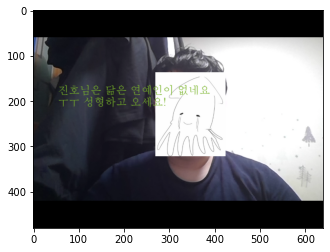

In [10]:
user_name = input("너의 이름은? ") # 사용자 이름 입력

cap = cv2.VideoCapture(0) # 노트북 웹캠을 카메라로 사용
cap.set(3,640) # 너비
cap.set(4,480) # 높이

while(True):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1) # 좌우 대칭
    
    cv2.imshow('frame', frame)
    
    k = cv2.waitKey(30) & 0xff 
    if k == 49: # 1 키를 누르면 사진 찍음.
        cap.release()
        cv2.destroyAllWindows()
        
        rects, shapes, _ = find_faces(frame) # 얼굴 찾기
        descriptors = encode_faces(frame, shapes) # 인코딩

        if(len(descriptors) == 0):
            print("얼굴 인식이 안되었네요ㅜㅜ \n다시 찍어주세요!")
        elif(len(descriptors) > 1):
            print("여러 명이 인식이 되었네요ㅜㅜ \n혼자 다시 찍어주세요!")
        else:
            desc = descriptors[0]
            x = rects[0][0][0] # 얼굴 X 좌표
            y = rects[0][0][1] # 얼굴 Y 좌표
            w = rects[0][1][1]-rects[0][0][1] # 얼굴 너비 
            h = rects[0][1][0]-rects[0][0][0] # 얼굴 높이        

            descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
            dist = np.linalg.norm([desc] - descs1[0][1], axis=1)
            if dist < 0.45:
                name = descs1[0][0]
                comment = "{0}을 닮으셨네요. 올~~".format(name) 
                img = cv2.imread(label_class[name])
#                 img = cv2.resize(img, dsize=(780, 520))
                result = draw(img, comment, x-10, y, h, 36)
            else:
                print(dist)
                comment = "{0}님은 닮은 연예인이 없네요\nㅜㅜ 성형하고 오세요!\n".format(user_name)
                img = cv2.imread("test_img/ojingeo1.png")
                img = cv2.resize(img, dsize=(w, h+30)) 
                frame[y-30:y+h, x:x+w] = img 
                result = draw(frame, comment, 50, 10, h, 24)

            print(comment)
#             cv2.imshow(name, result)
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # BGR -> RGB
            plt.imshow(result)

        break
    
cv2.waitKey(0)
cv2.destroyAllWindows()